In [88]:
import os
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import hypergeom
from scipy.cluster import hierarchy
import networkx as nx

In [89]:
#set seed for reproducibility
np.random.seed(42)

In [90]:
# Read SNP and eQTL files for each disease, map SNPs to genes
snp_directory_path = 'FUMA_dowloads_all_tissue/SNPs'
eqtl_directory_path = 'FUMA_dowloads_all_tissue/eQTL'

# Initialize list to store dataframes 
snp2eqtl_dfs = []

# Iterate through SNP and eQTL directories simultaneously
for snp_file, eqtl_file in zip(os.listdir(snp_directory_path), os.listdir(eqtl_directory_path)):
    if snp_file.endswith('.txt') and eqtl_file.endswith('.txt'):
        # Extract disorder name from the filename
        disease_name = snp_file.split('_')[1].split('.')[0]

        # Read SNP and eQTL files
        df_snps = pd.read_csv(os.path.join(snp_directory_path, snp_file), sep='\t')
        df_eqtl = pd.read_csv(os.path.join(eqtl_directory_path, eqtl_file), sep='\t', low_memory=False)

        # Filter relevant SNPs
        relevant_snps = df_snps[df_snps['uniqID'].isin(df_eqtl['uniqID'].unique())]
        dict1 = dict(zip(relevant_snps['uniqID'], relevant_snps['rsID']))

        # Add rsID and disease column to df_eqtl
        df_eqtl['rsID'] = df_eqtl['uniqID'].map(dict1)
        df_eqtl['disease'] = disease_name
        # Filter columns in df_eqtl
        df_final = df_eqtl[['rsID', 'symbol', 'db', 'tissue', 'disease']].dropna()

        snp2eqtl_dfs.append(df_final)

In [92]:
snp2eqtl_dfs[28]

,rsID,symbol,db,tissue,disease
0,rs10858000,DCLRE1B,TIGER,Nom_Alonso_Pancreatic_islets,SLE
1,rs11102648,DCLRE1B,TIGER,Nom_Alonso_Pancreatic_islets,SLE
2,rs11102649,DCLRE1B,TIGER,Nom_Alonso_Pancreatic_islets,SLE
3,rs4456089,DCLRE1B,TIGER,Nom_Alonso_Pancreatic_islets,SLE
4,rs71962960,DCLRE1B,TIGER,Nom_Alonso_Pancreatic_islets,SLE
...,...,...,...,...,...
3571922,rs7444,CCDC116,GTEx/v6,Vagina,SLE
3571923,rs11089637,CCDC116,GTEx/v6,Vagina,SLE
3571924,rs878825,CCDC116,GTEx/v6,Vagina,SLE
3571925,rs2298429,CCDC116,GTEx/v6,Vagina,SLE


In [93]:
def make_binary_matrix(df_list, column1,column2):
    concatenated= pd.concat(df_list)
    df = concatenated[[column1, column2]]
    
    return df.pivot_table(index=column1, columns=column2, aggfunc=lambda x: 1, fill_value=0)

In [94]:
all_snps_binary = make_binary_matrix(snp2eqtl_dfs, 'rsID', 'disease')
all_genes_binary = make_binary_matrix(snp2eqtl_dfs,'symbol', 'disease')

In [ ]:
all_snps_binary.to_csv('snps_binary.csv')

In [95]:
print(all_snps_binary.sum(axis=0))


disease
ADHD                15782
ANOREXIA             5558
ANXIETY               354
ASD                  6148
AUD                 10128
BILIARYCHIRROSIS    21224
BPD                 26313
CHRONICPAIN          4646
CUD                  3436
ENDOMETRIOSIS        1410
EPILEPSY              595
FATIGUE               785
GDM                   941
GH                    364
GOUT                 4302
HOARDING              392
IBD                   432
IBS                   404
MDD                 23335
MIGRAINE             5204
MS                   9357
MYASTHENIAGRAVIS      105
OCD                   538
PARKINSONS           9436
PREECLAMPSIA         1736
PTSD                  828
RA                  23342
SJOGRENS              692
SLE                 19655
SZC                 75342
THYROIDDISEASE          6
TOURETTES            1289
dtype: int64


In [96]:
print(all_genes_binary.sum(axis=0))


disease
ADHD                1135
ANOREXIA             474
ANXIETY               43
ASD                  308
AUD                  678
BILIARYCHIRROSIS    2434
BPD                 2440
CHRONICPAIN          435
CUD                  308
ENDOMETRIOSIS        104
EPILEPSY              28
FATIGUE               73
GDM                   81
GH                    38
GOUT                 325
HOARDING              42
IBD                  101
IBS                   23
MDD                 1485
MIGRAINE             566
MS                  1579
MYASTHENIAGRAVIS      47
OCD                   44
PARKINSONS           802
PREECLAMPSIA         656
PTSD                 128
RA                  2660
SJOGRENS              71
SLE                 1888
SZC                 4149
THYROIDDISEASE        10
TOURETTES            164
dtype: int64


In [ ]:
# function to find the largest number of disorders in a combination 
def find_max_row(binary_df):
    row_sums = binary_df.sum(axis=1)

    # Find the maximum sum
    max_row_sum = row_sums.max()
    
    print("Maximum number of 1's in the row:", max_row_sum)
    return max_row_sum

In [ ]:
max_combo_snps = find_max_row(all_snps_binary)
max_combo_genes = find_max_row(all_genes_binary)

In [ ]:
def count_combos(binary_df, max_combo):

    num_iterations = 10

    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create an empty DataFrame with rows as each combination and columns for storing counts in each iteration
    counts_df = pd.DataFrame(index=all_combinations, columns=range(1,num_iterations+1))

    # Perform the iterations
    for i in range(1,num_iterations+1):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        iteration_counts = []

        # Count occurrences for each combination in this iteration
        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the dataFrame
        counts_df[i] = iteration_counts

    return counts_df

In [ ]:
def count_combos_real_data(binary_df, max_combo):
#Count all occurrences for each combination and store in a new dataframe

    # Get all possible combinations of disorders 
    all_combinations = []
    for r in range(2,max_combo):
        all_combinations.extend(list(combinations(binary_df.columns, r)))
        
    #Create empty dataframe to store the count
    count_df = pd.DataFrame(index=all_combinations, columns=['Count'])

    iteration_counts = []

    # Count occurrences for each combination in this iteration 
    for combo in all_combinations:
        # Check if all disorders in the combination are present in each row
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        iteration_counts.append(count)

    # Store the counts for this iteration in the counts_df DataFrame
    count_df['Count'] = iteration_counts
    
    return count_df


In [ ]:

all_snps_randomized = count_combos(all_snps_binary, 6)
all_genes_combo_count = count_combos_real_data(all_genes_binary, 6)
all_genes_randomized = count_combos(all_genes_binary, 6)
all_snps_combo_count = count_combos_real_data(all_snps_binary, 6)




In [ ]:
#function to calculate z-scores and sort the result

def calculate_z_score(df, df_rand, threshold, count):
    
    #calculate mean and standard deviation
    means = round(df_rand.mean(axis=1),2)
    std = round(df_rand.std(axis=1),2)

    df_rand['mean'] = means
    df_rand['std'] = std
    df_rand['actual'] = df['Count']
    
    new_df = df_rand[['actual', 'mean', 'std']]
    
    #Make copies to avoid warnings
    new_df_copy = new_df.copy()
    
    
    # Calculate Z-scores 
    new_df_copy['z-score'] = round((new_df_copy['actual'] - new_df_copy['mean']) / new_df_copy['std'],2)
    
    
    sorted_df = new_df_copy.sort_values(by='z-score', ascending=False)
    
    # Replace infinite values in the "z-score" column with NaN
    sorted_df['z-score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values in the "z-score" column
    sorted_df.dropna(subset=['z-score'], how='any', inplace=True)

    return sorted_df[(sorted_df['z-score'] >= threshold) & (sorted_df['actual'] >= count)]    

In [ ]:
z_all_snps2 = calculate_z_score(all_snps_combo_count, all_snps_randomized,2,5)
z_all_genes2 = calculate_z_score(all_genes_combo_count, all_genes_randomized,2,5)

In [ ]:
z_all_genes2.head()

In [ ]:
z = {'No. of combinations with z-value >= 2':[len(z_all_snps2),len(z_all_genes2)]}
z_df = pd.DataFrame(data=z, index=['SNPs', 'Genes'])

In [ ]:
z_df

In [ ]:
link = hierarchy.linkage(all_snps_binary.T, method='average', metric='hamming')
# Plot the dendrogram
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(link, labels=all_snps_binary.columns)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Hierarchical Clustering Dendrogram SNPs')
plt.xticks(rotation=90)
plt.show()  

In [ ]:
# select top 500 SNPs/genes ranked by significance
top_snp_list = []
for df in snp2eqtl_dfs:
    sorted = df.sort_values(by=['gwasP'])
    top_snps = sorted.iloc[:500]
    top_snps.reset_index(drop=True,inplace=True)
    top_snp_list.append(top_snps)

In [ ]:
#  randomly select a given number of SNPs

all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(5):
    sampled_dfs = []
    for df in top_snp_list:
        sampled = df.sample(100, axis=0, replace=True)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_matrix(sampled_dfs, 'rsID', 'disorder')
    

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

# Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram sampled from top 500 SNPs/genes')
    plt.xticks(rotation=90)
    plt.show()  

# Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix, disorders_of_interest):
    overlaps = []
    overlapping_genes = set()

    for index, row in binary_matrix.iterrows():
        ones = {col for col, val in row.items() if val == 1 and col in disorders_of_interest}

        if ones and ones == set(disorders_of_interest):
            overlaps.append((index, ones))
            overlapping_genes.add(index)

    return overlaps, list(overlapping_genes) 


In [ ]:
dis_of_int = ['SZC','BPD']
overlapping_genes, gene_list = find_overlaps(all_genes_binary, dis_of_int)
#overlapping_snps = find_overlaps(all_snps_binary)

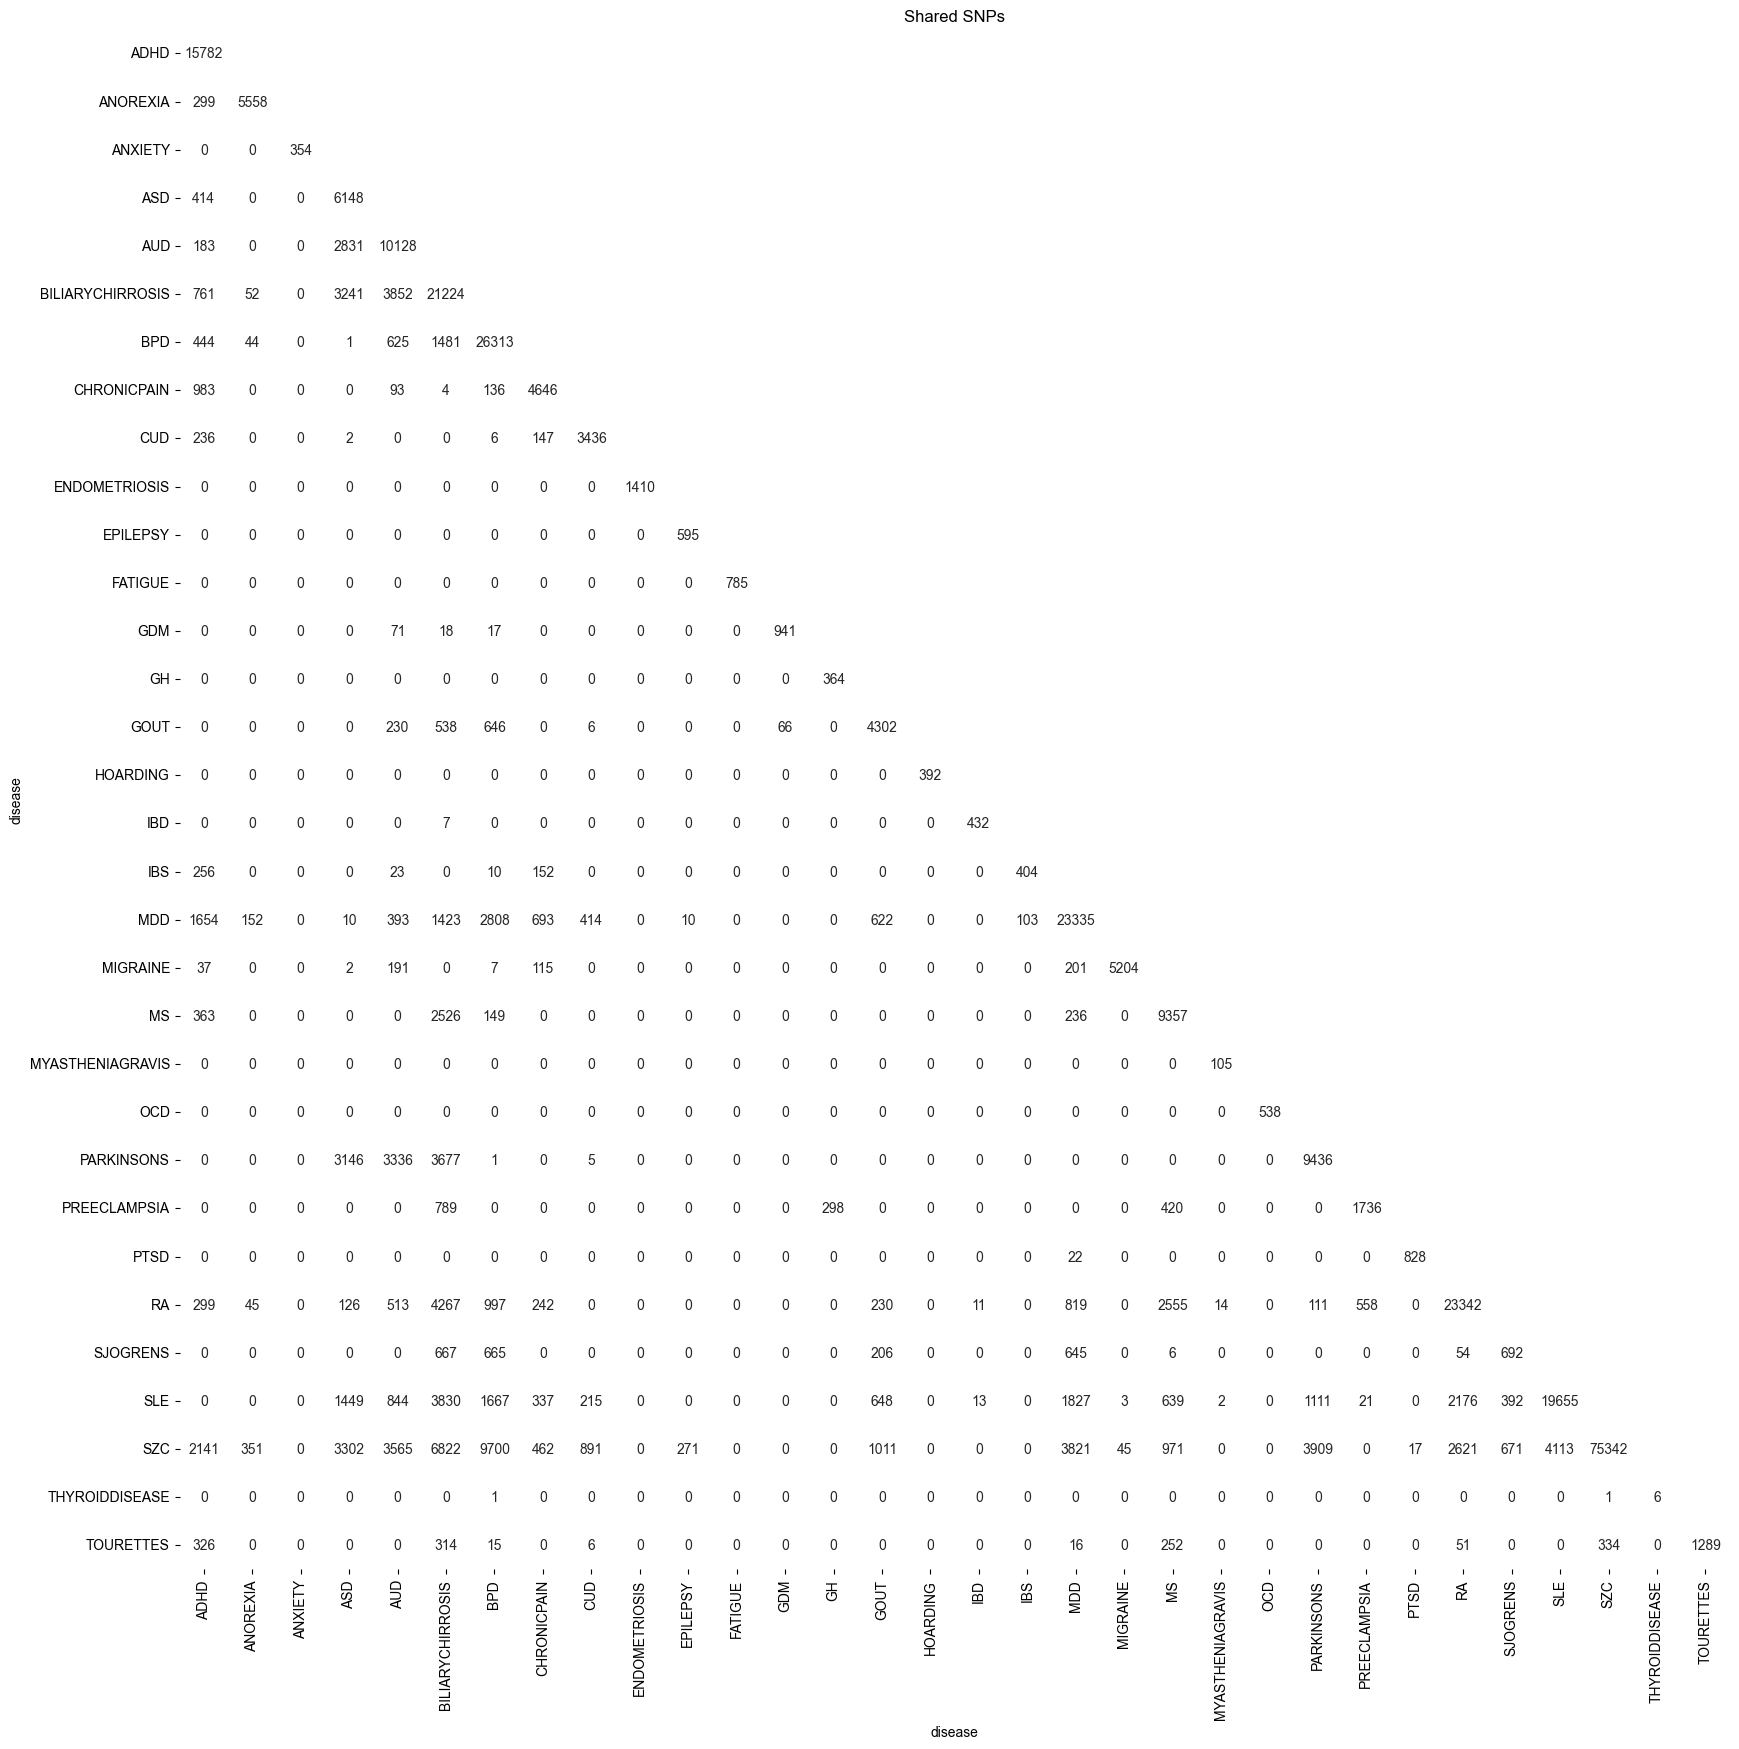

In [97]:
shared_snps = pd.DataFrame(index=all_snps_binary.columns, columns=all_snps_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_snps_binary.columns:
    for disorder2 in all_snps_binary.columns:
        count=sum(all_snps_binary[disorder1] & all_snps_binary[disorder2])
        shared_snps.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_snps_binary.columns:
    total_count = all_snps_binary[disorder].sum()
    shared_snps.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders_snps = shared_snps.columns.tolist()
disorder_matrix_snps = shared_snps.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_snps), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_snps[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_snps, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared SNPs')
    plt.show()

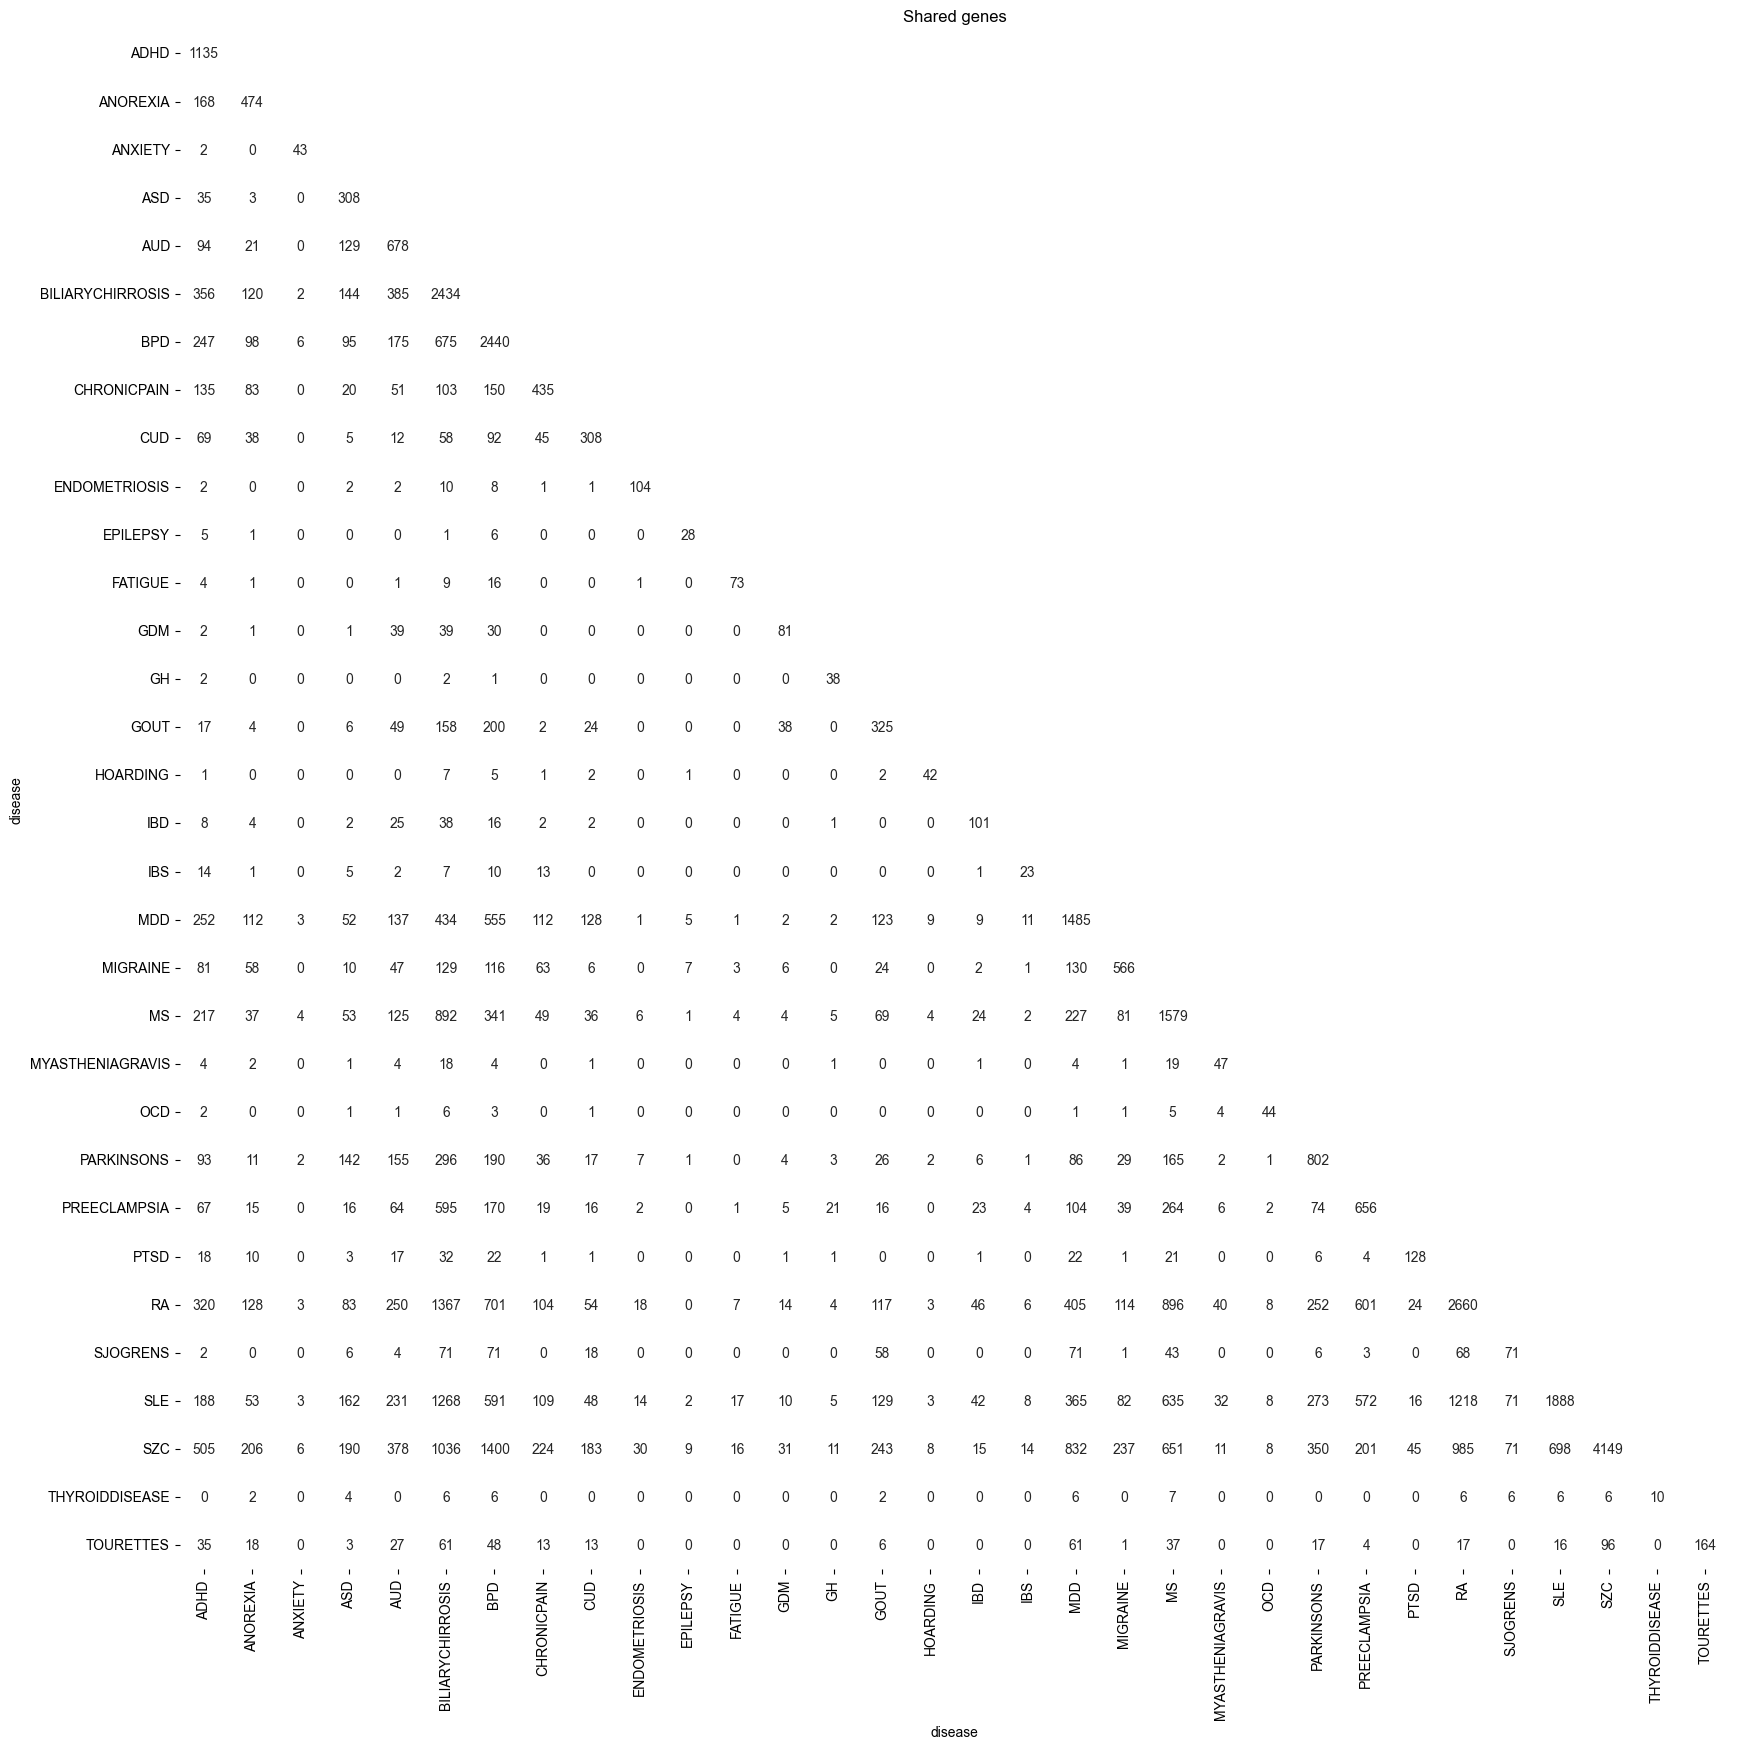

In [98]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared genes')
    plt.show()

In [99]:

def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

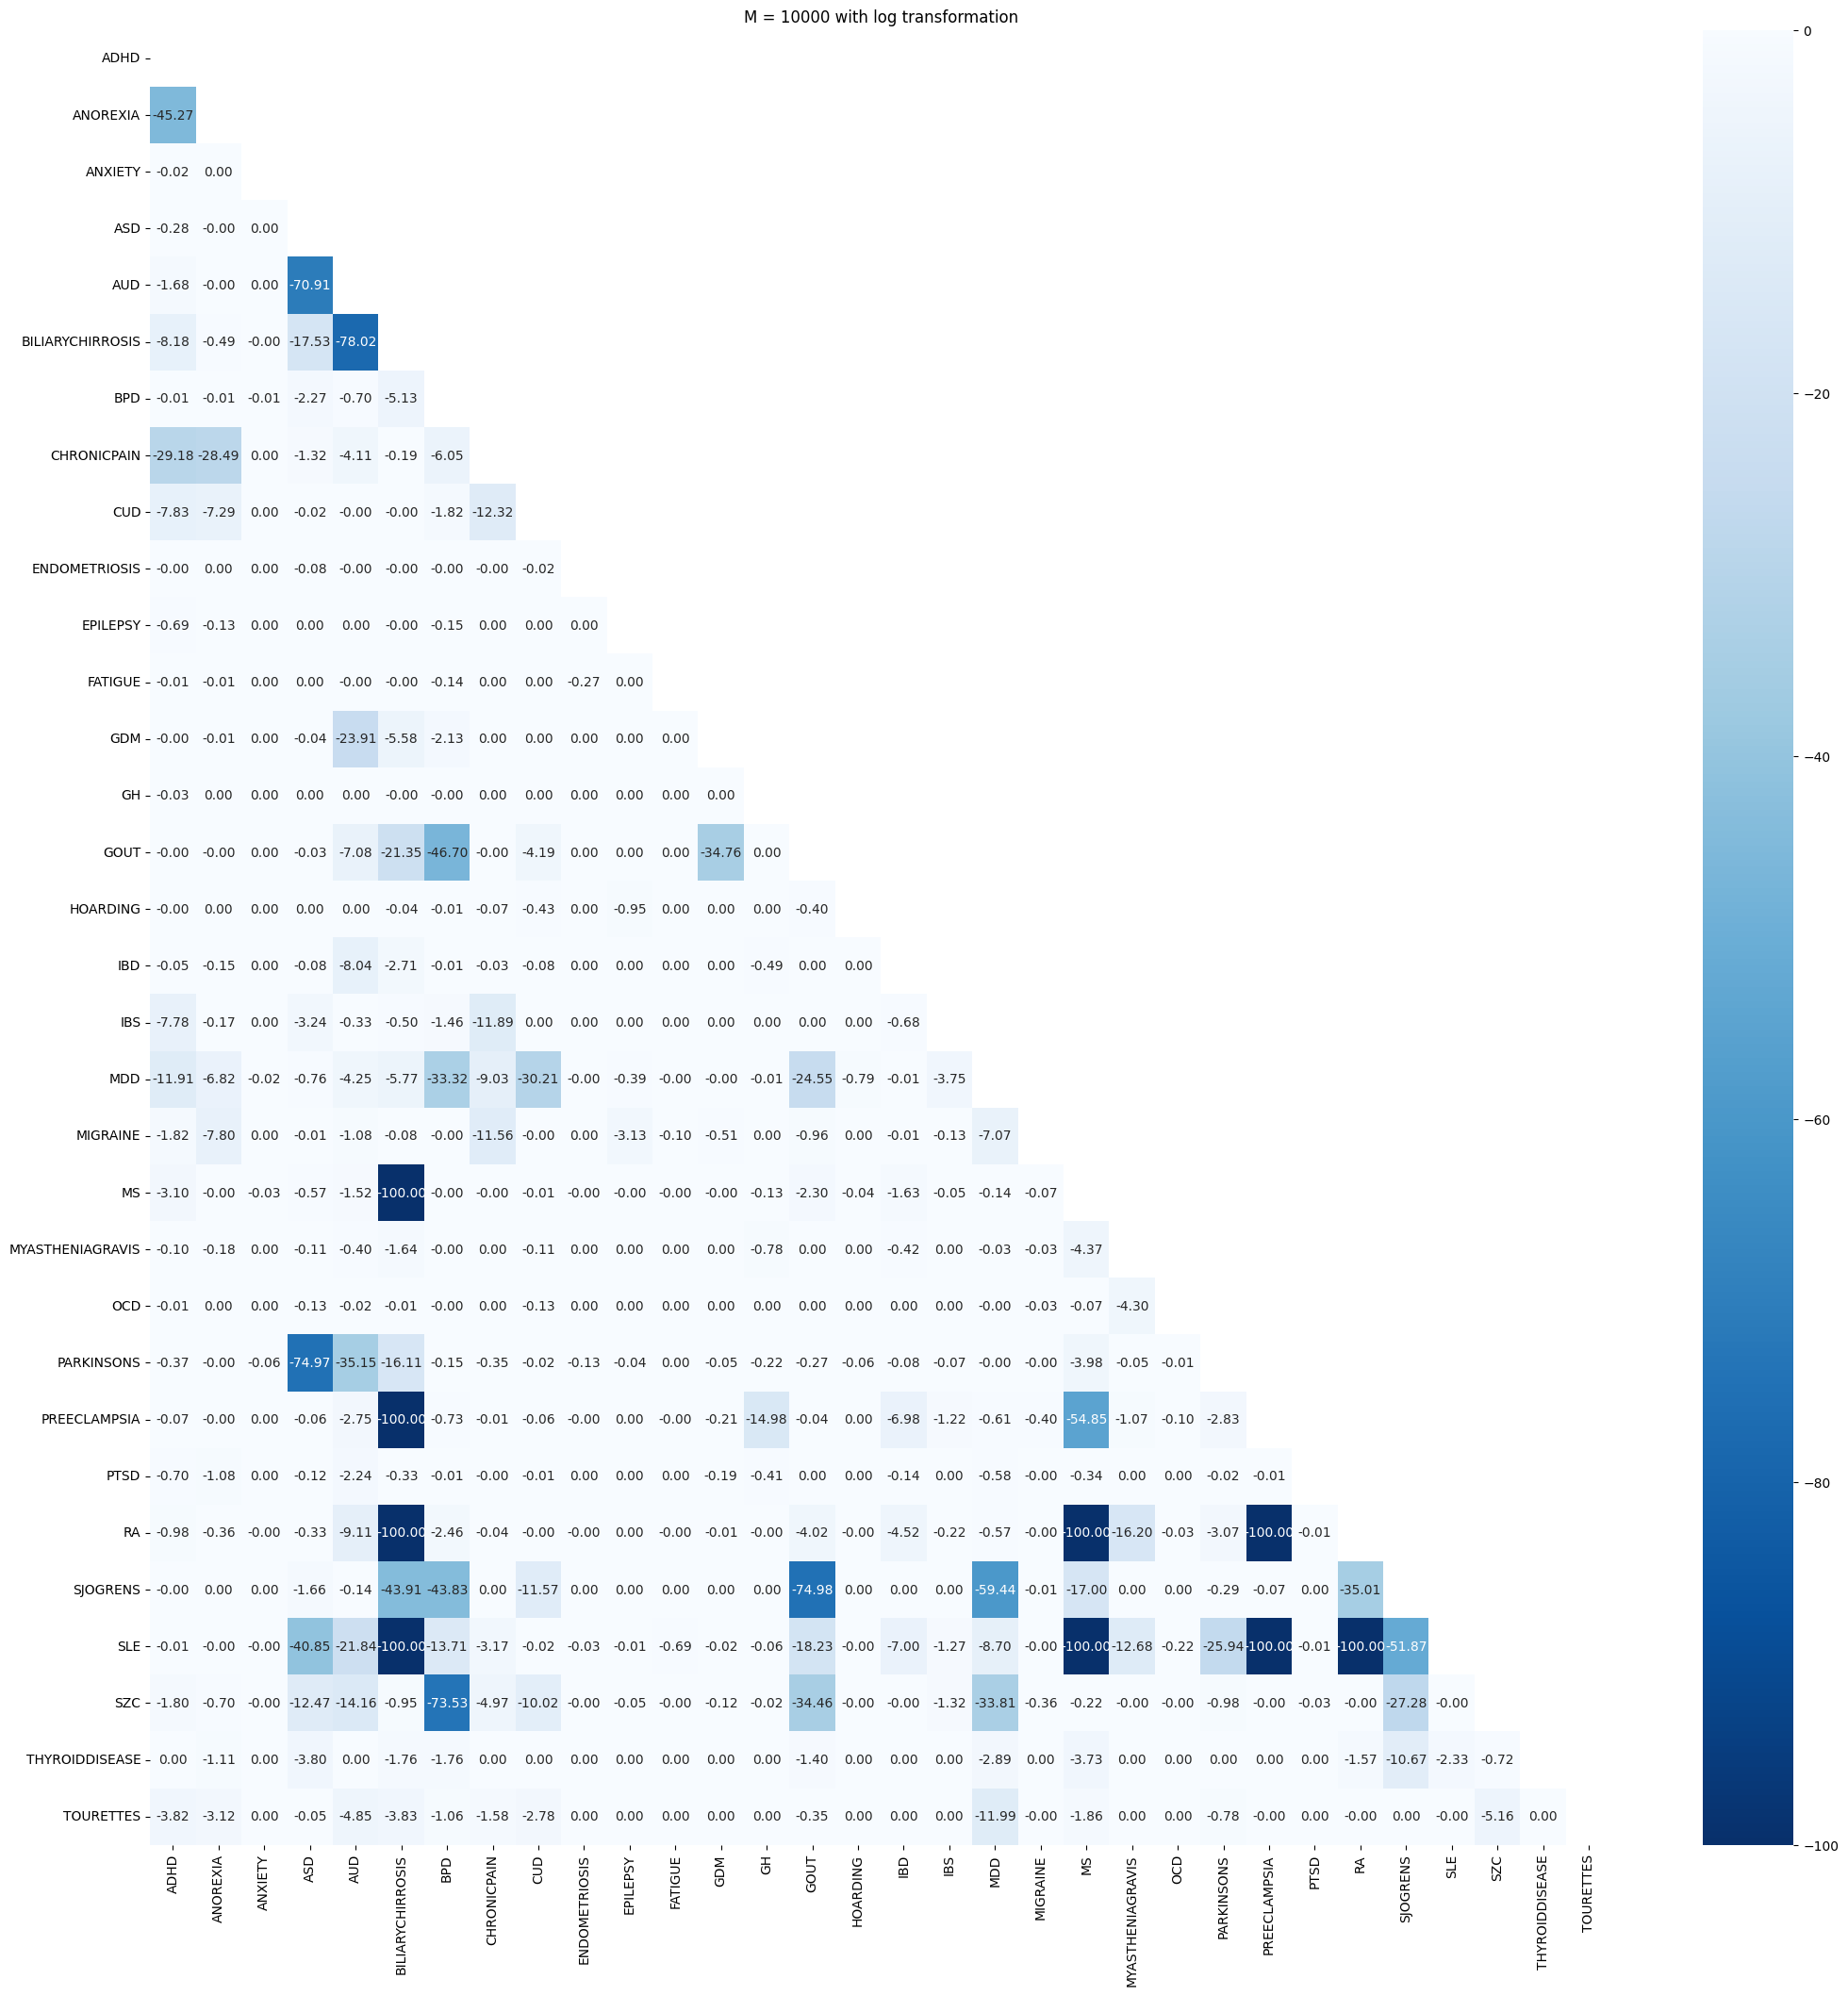

<Figure size 2500x2500 with 0 Axes>

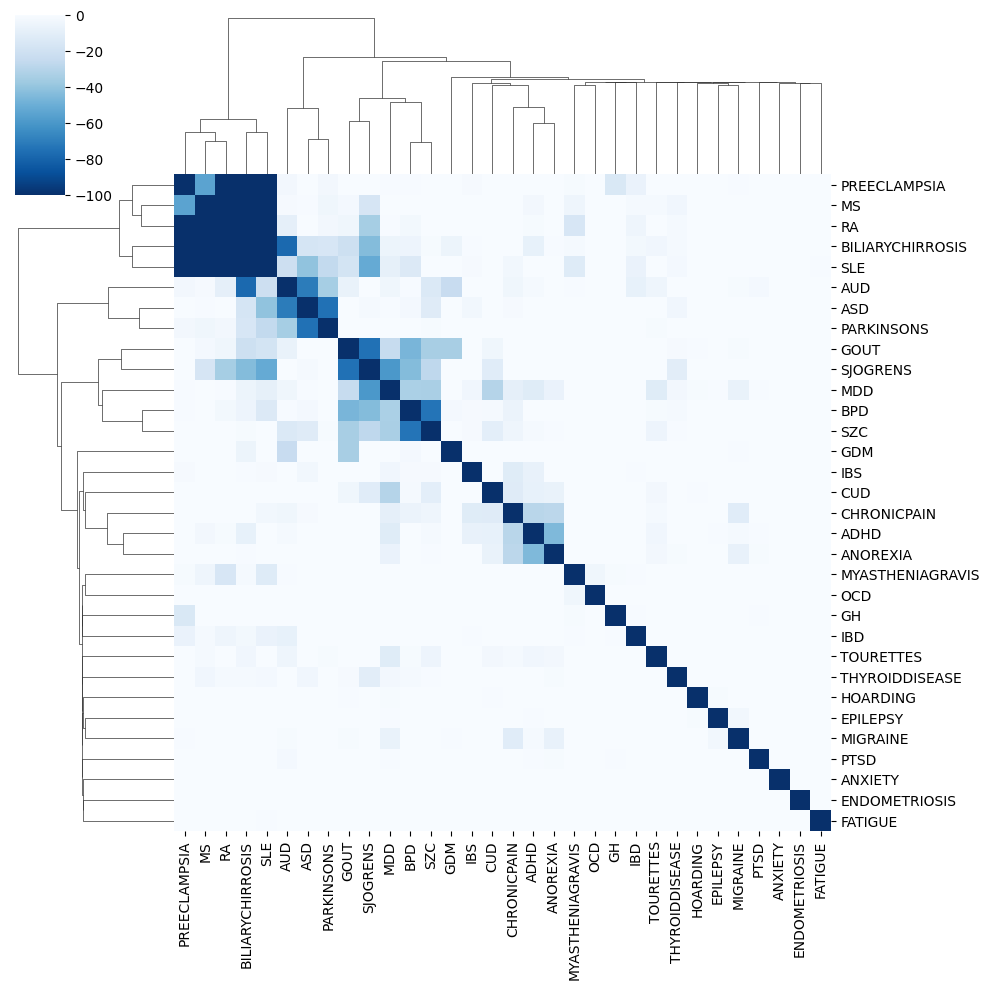

In [100]:
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
    
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(prob_genes_10K, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
prob_genes_10K = prob_genes_10K.mask(mask)

#Apply log transformation
prob_genes_10K_log = np.log10(prob_genes_10K+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,25))
plt.title('M = 10000 with log transformation')
sns.heatmap(prob_genes_10K_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

prob_genes_10Kfull_matrix = np.tril(prob_genes_10K) + np.tril(prob_genes_10K, -1).T

prob_genes_10Kfull_df = pd.DataFrame(prob_genes_10Kfull_matrix, index=disorders, columns=disorders)
prob_genes_10Kfull_df = prob_genes_10Kfull_df.fillna(1e-100)
prob_genes_10Kfull_df_log = np.log10(prob_genes_10Kfull_df + 1e-100)

plt.figure(figsize=(25,25))
sns.clustermap(prob_genes_10Kfull_df_log,cmap=cmap_reversed)

plt.show()

    
    

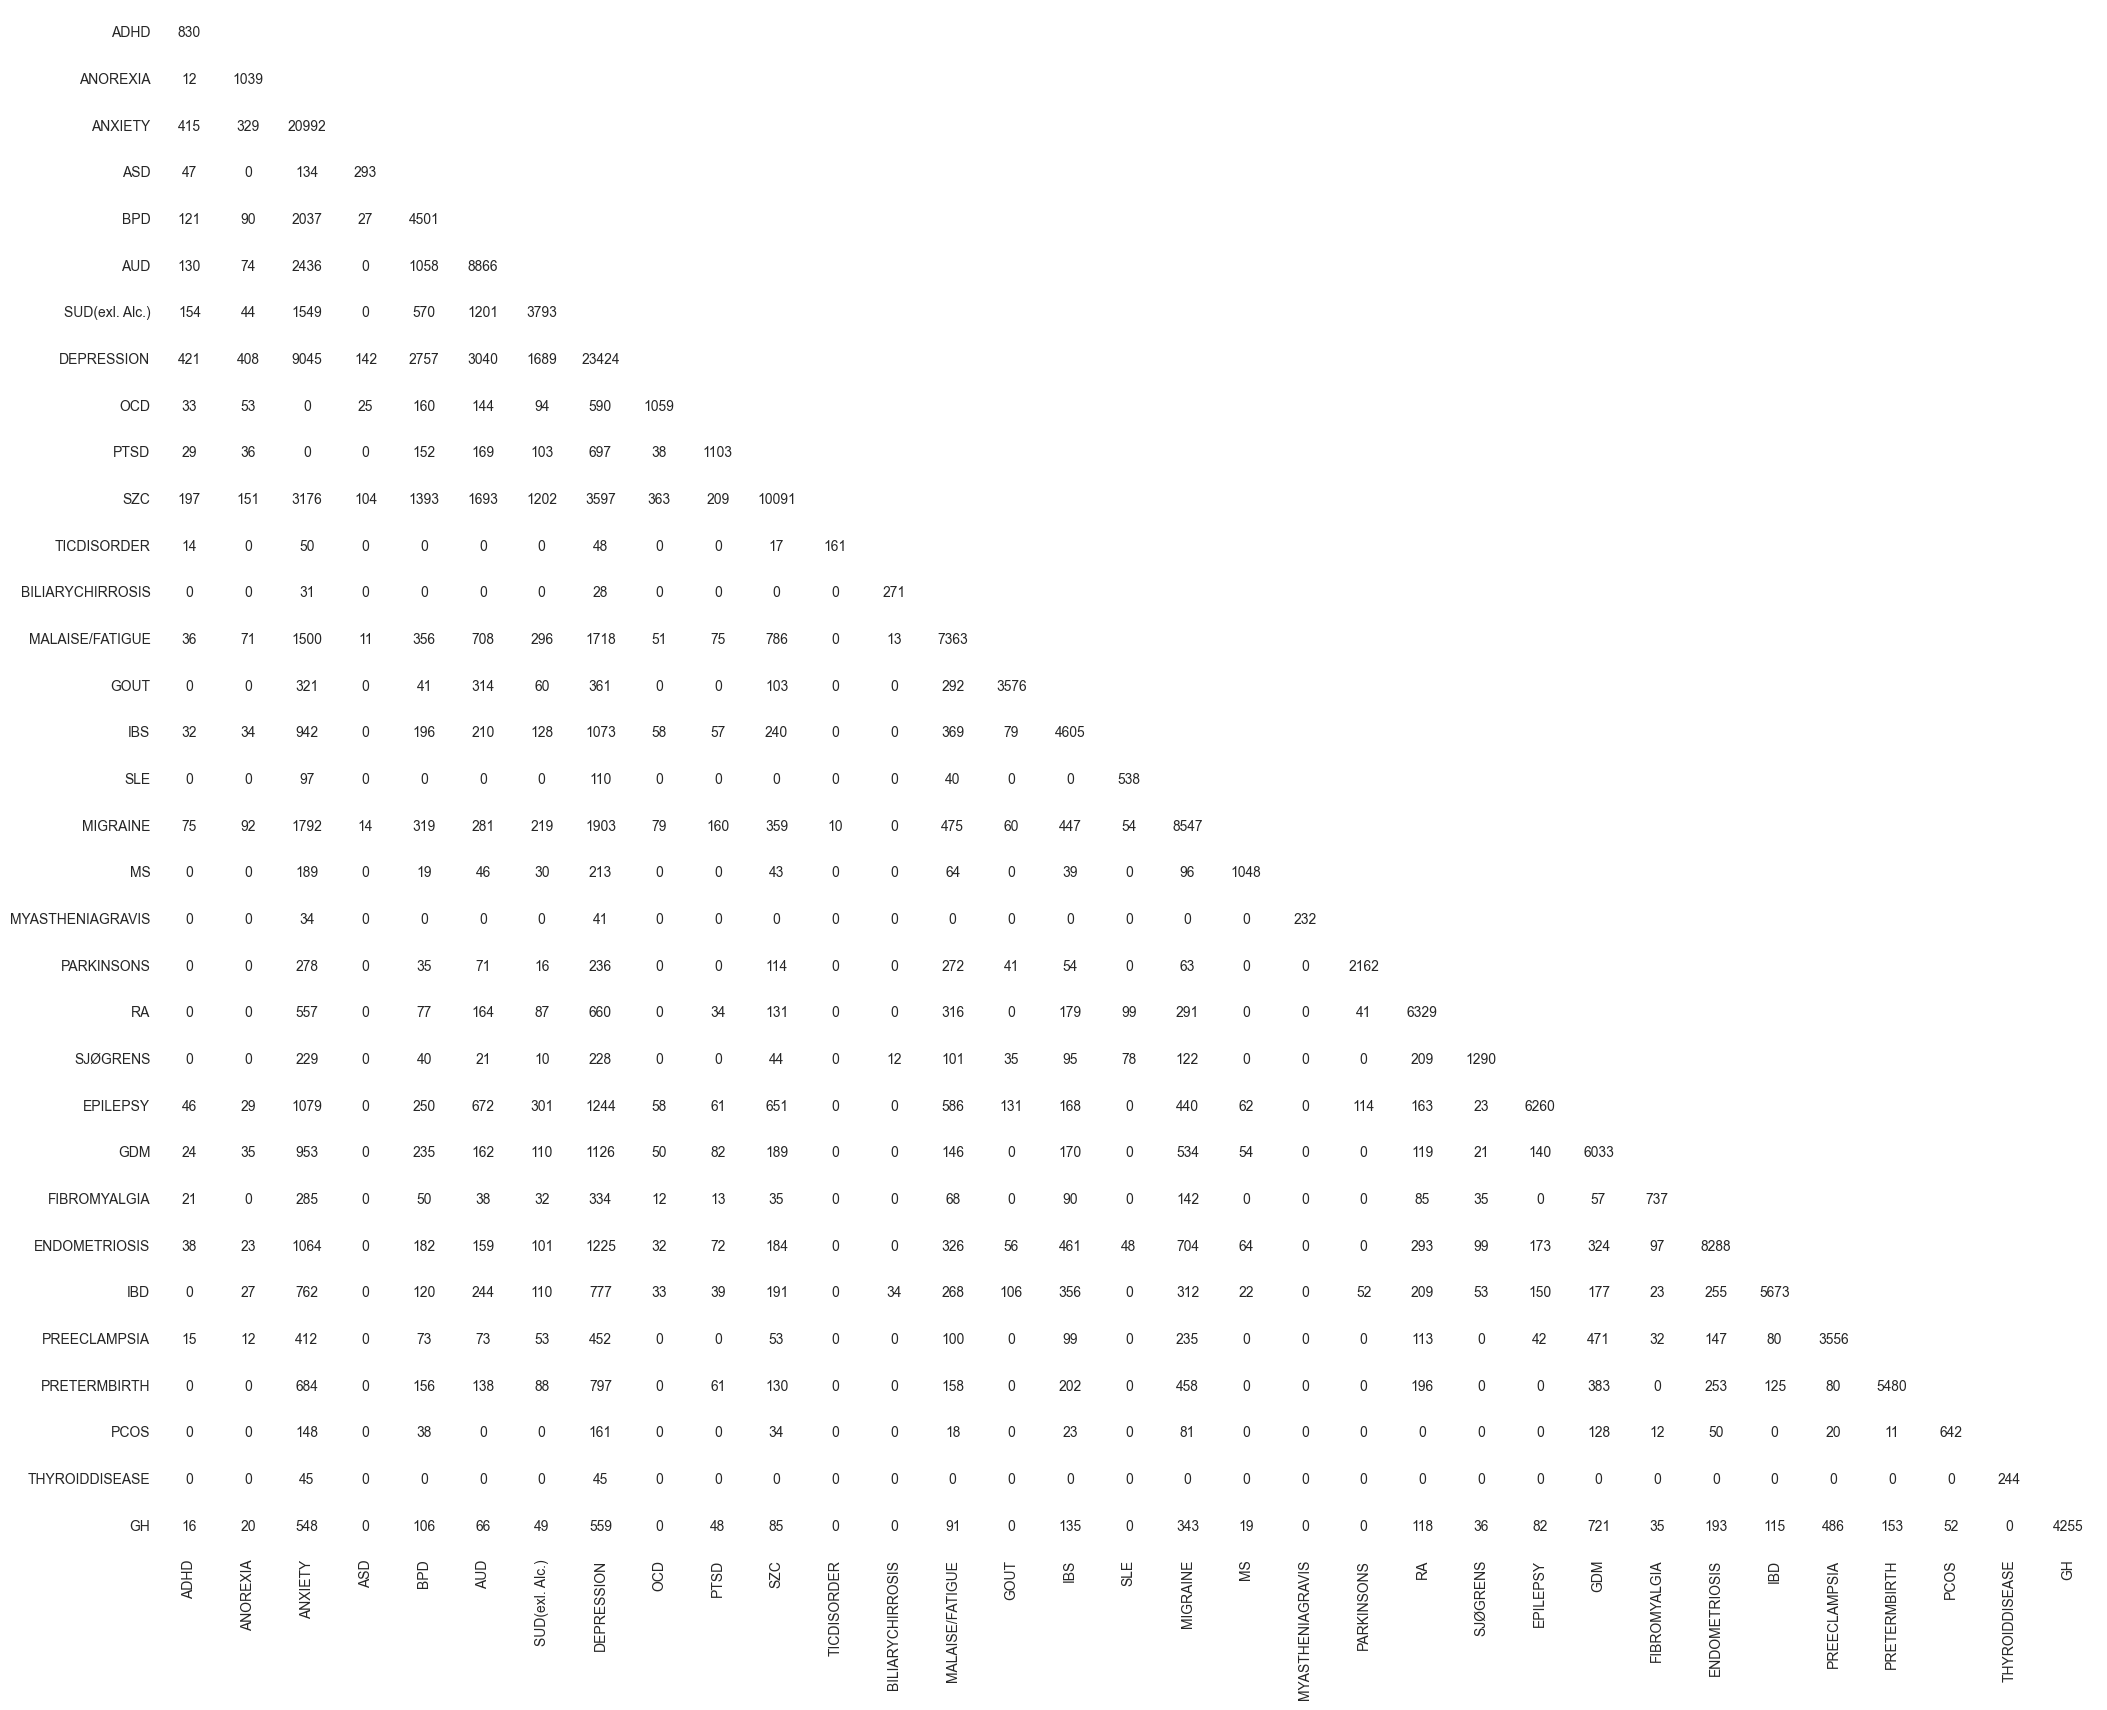

In [101]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()
full_finngen_matrix2 = np.tril(finngen) + np.tril(finngen, -1).T
finngen2 = pd.DataFrame(full_finngen_matrix2, index=disorder_list, columns=disorder_list)

# Create a mask for the diagonal
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

plt.figure(figsize=(25,20))
with sns.axes_style('white'):
    sns.heatmap(finngen2,cmap=ListedColormap(['white']), annot=True, fmt='.0f', mask=mask, cbar=False)
    plt.show()

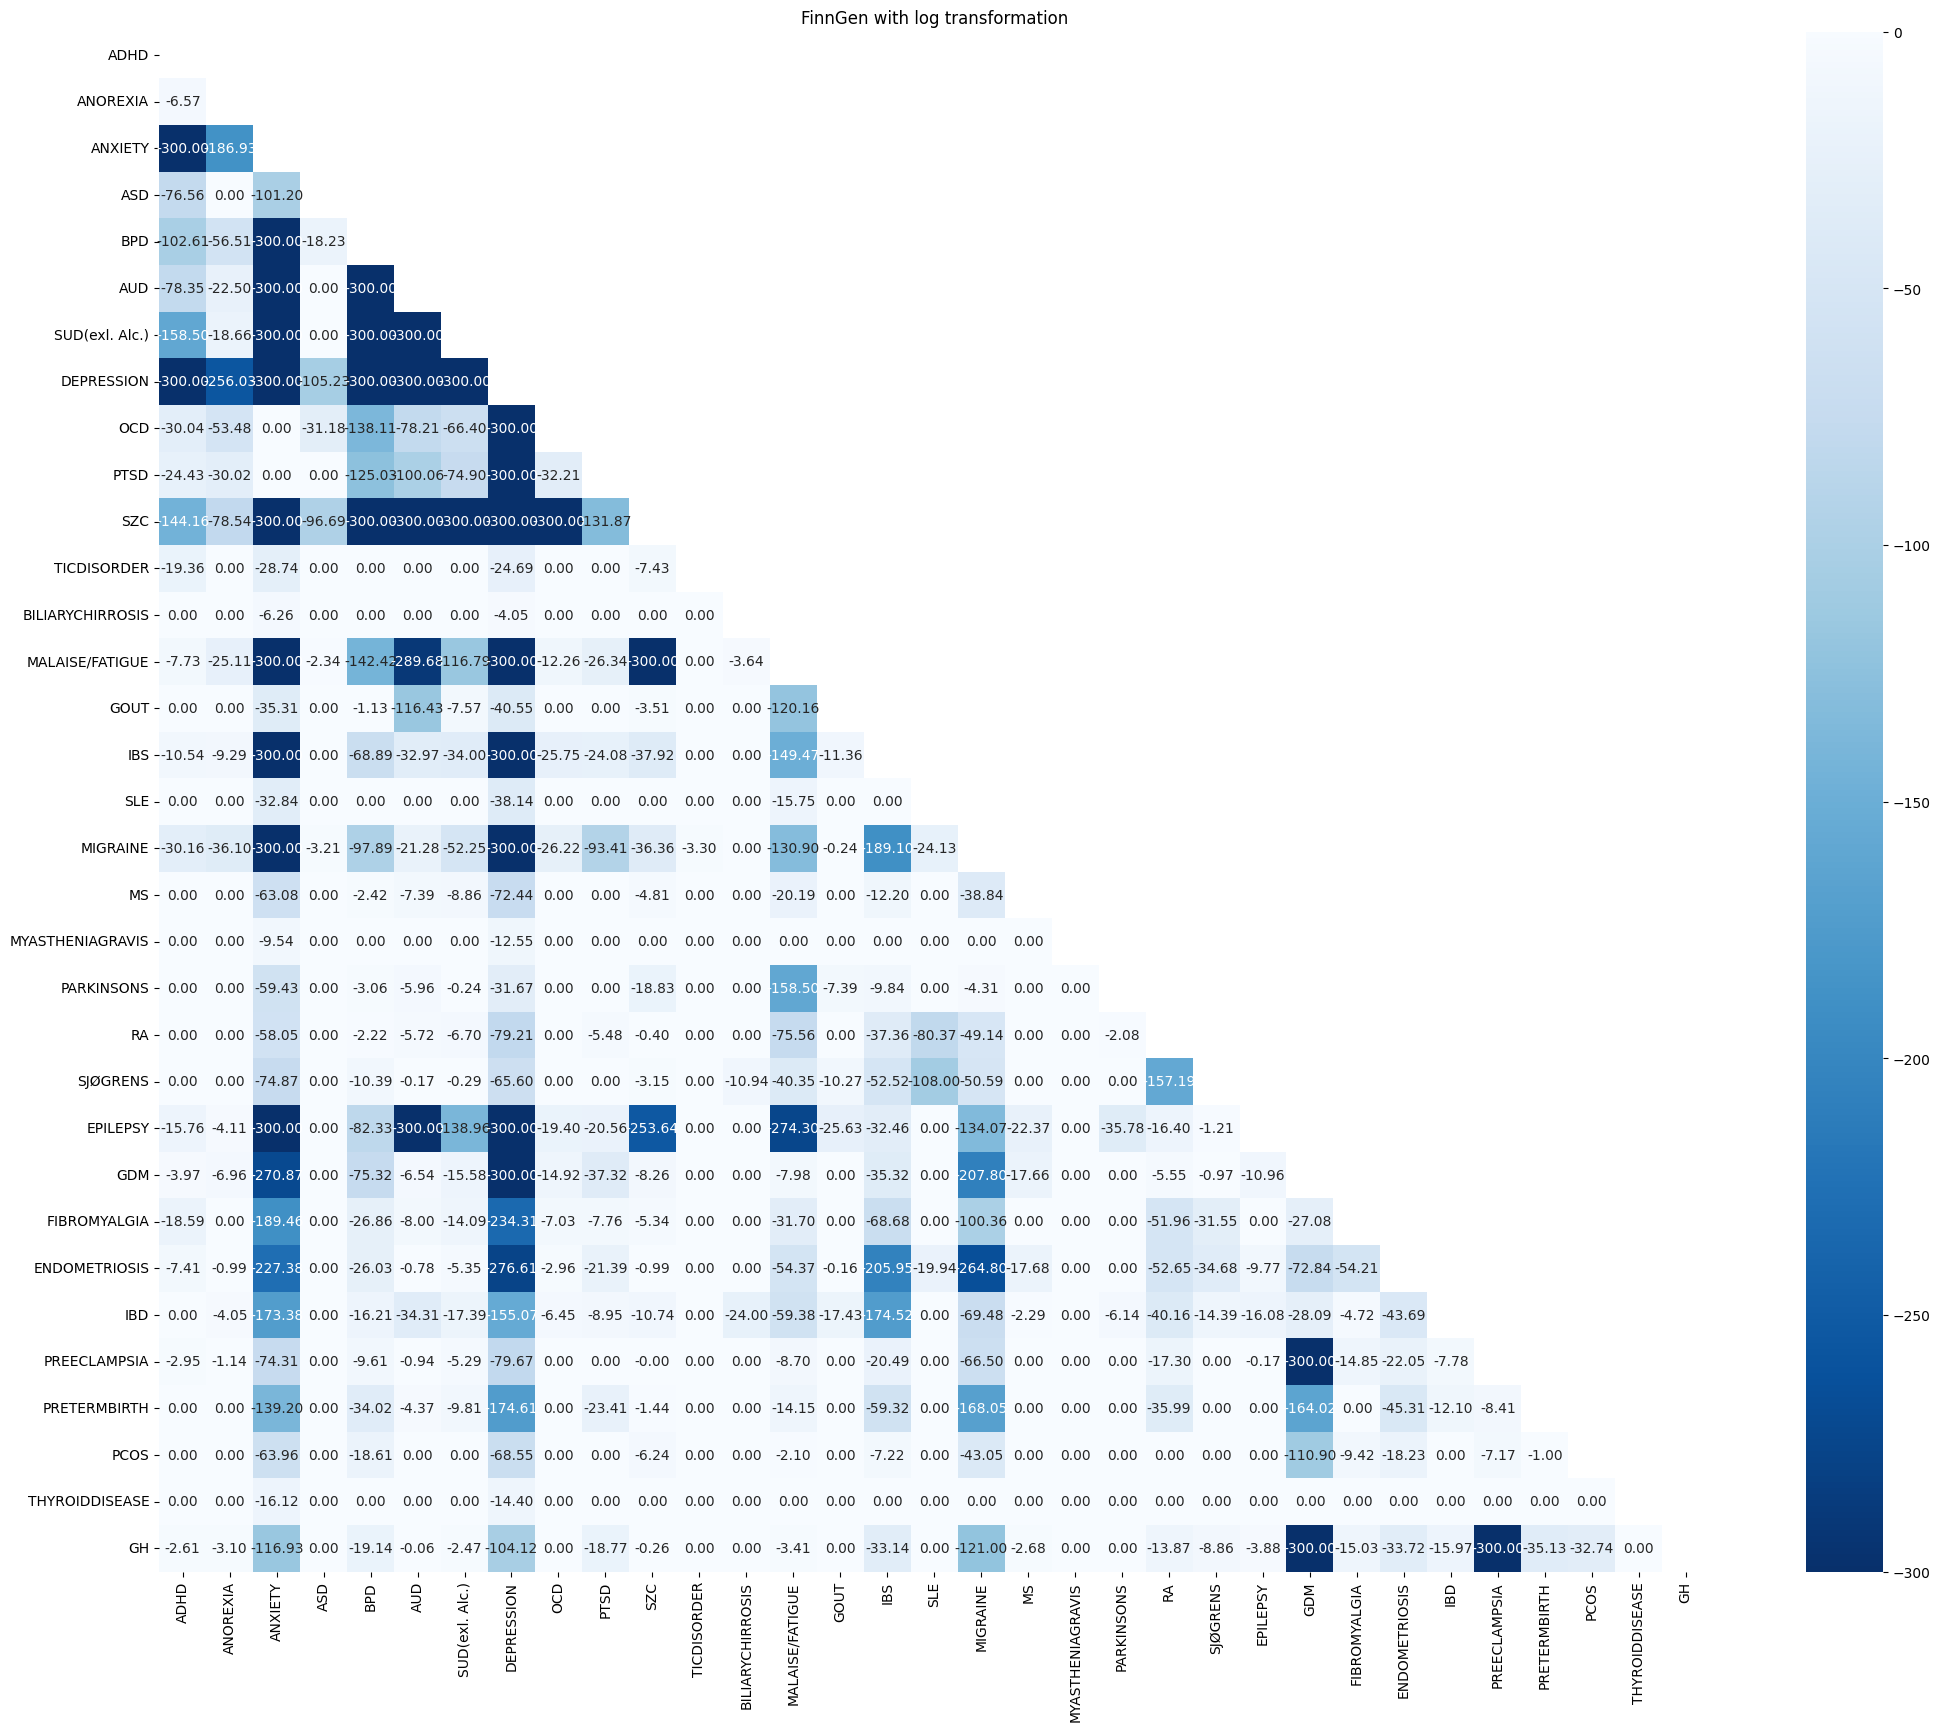

<Figure size 2000x1500 with 0 Axes>

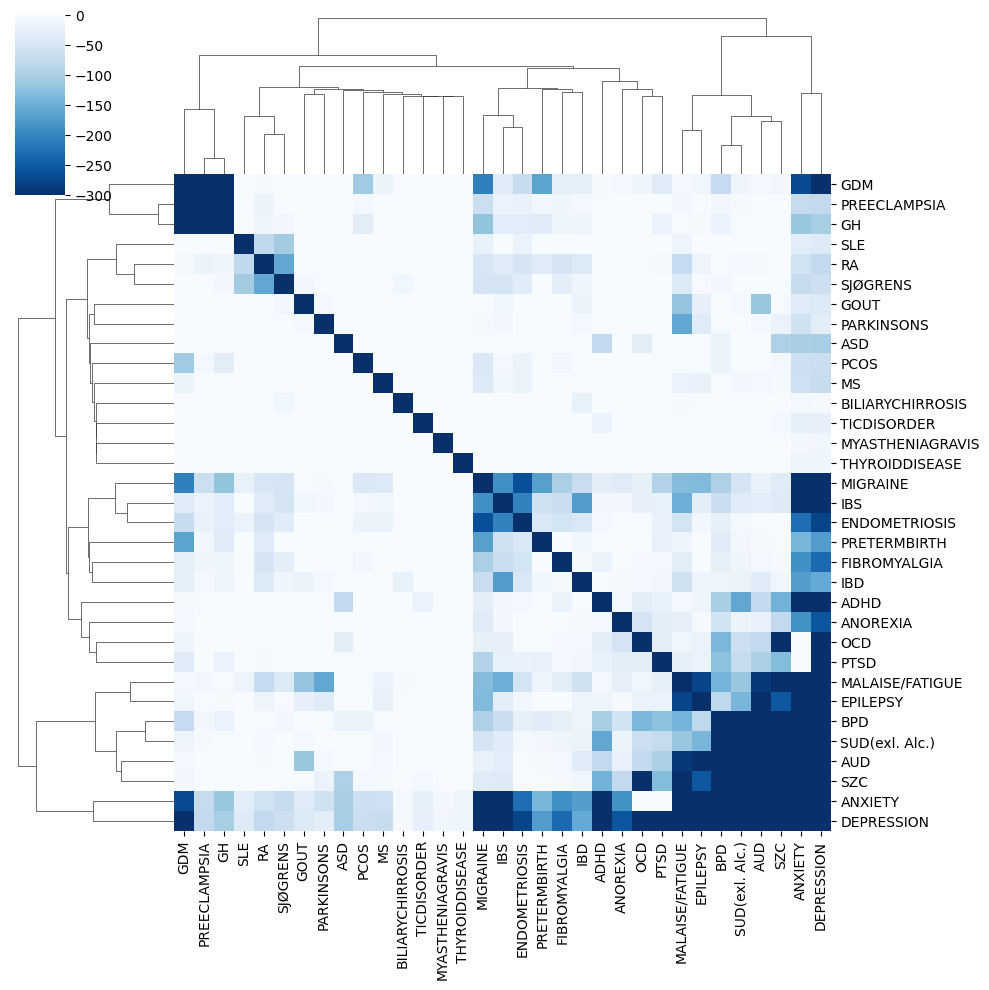

In [102]:
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation
finngen_log = np.log10(finngen_p+1e-300)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T
full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorder_list, columns=disorder_list)
full_finngen_df = full_finngen_df.fillna(1e-300)
full_finngen_log = np.log10(full_finngen_df+1e-300)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


In [132]:
# Create a graph from the PPI network
biogrid = pd.read_csv('BIOGRID2.tab.txt', sep='\t')

G = nx.Graph()

for index, row in biogrid.iterrows():
    source_node = row['OFFICIAL_SYMBOL_A']
    target_node = row['OFFICIAL_SYMBOL_B']
       
    G.add_edge(source_node, target_node)

In [168]:
diseases_of_interest = ['PREECLAMPSIA', 'MS','RA','BILIARYCHIRROSIS','SLE']
#diseases_of_interest = ['PREECLAMPSIA']
for df in snp2eqtl_dfs:
    disease = df.iloc[0]['disease']
    if disease in diseases_of_interest:
    
        subset_of_nodes = df['symbol'].drop_duplicates().tolist()

        #subset_of_nodes = subset_of_nodes[:100]

        # Create a new graph to store the shortest paths
        H = nx.Graph()

        # Find the shortest path between each pair of nodes in the subset
        for i in range(len(subset_of_nodes)):
            for j in range(i + 1, len(subset_of_nodes)):
                node_i = subset_of_nodes[i]
                node_j = subset_of_nodes[j]
                
                # Check if both nodes exist in graph G
                if node_i in G and node_j in G:
                    try:
                        # Calculate shortest path if nodes exist in G
                        path = nx.shortest_path(G, node_i, node_j)
                        if len(path) <= 2: # the number refers to nodes, not edges
                            
                            path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                            #print(len(path), path, path_edges)
                            H.add_edges_from(path_edges)
                    except nx.NetworkXNoPath:
                        continue
                else:
                    continue

        # Find the minimum spanning tree of the new graph
        mst = nx.minimum_spanning_tree(H, algorithm='kruskal')

         # Convert MST edges to DataFrame
        """ mst_edges = list(mst.edges())
        mst_df = pd.DataFrame(mst_edges, columns=['Node1', 'Node2']) """

        # Save DataFrame to CSV
        #mst_df.to_csv(f'{disease}_MST.csv', index=False)

        # Find the leaves (outermost nodes) in the MST
        #leaves = [node for node, degree in mst.degree() if degree == 1]

        # Prune the MST by removing the leaves
        #pruned_mst = mst.copy()  # Make a copy to avoid modifying the original MST
        #pruned_mst.remove_nodes_from(leaves)

        hub_threshold = 10  

        # Calculate the degree of each node in the pruned MST
        node_degrees = dict(mst.degree())

        # Create a list to store node colors
        node_colors = ['skyblue' if node in subset_of_nodes else 'lightgreen' for node in mst.nodes]

        # Highlight hubs by modifying node labels to bold
        node_labels = {node: node if mst.degree[node] > hub_threshold else '' for node in mst.nodes}
        
        node_color_map = dict(zip(mst.nodes, node_colors))

        plt.figure(figsize=(10, 8))
        pos = nx.spring_layout(H)  # Position nodes using a spring layout
        nx.draw(H, pos, with_labels=True, node_color='skyblue', edge_color='black', font_size=10, node_size=2000)
        plt.title("Tree with shortest path")
        
        # Plot the pruned MST with modified node labels
        plt.figure(figsize=(20,15))
        pos = nx.spring_layout(mst, seed=42)
        nx.draw_networkx_nodes(mst, pos, node_size=1000, node_color=node_colors)
        nx.draw_networkx_edges(mst, pos, edge_color='red', width=2)
        nx.draw_networkx_labels(mst, pos, labels=node_labels, font_size=10, font_color='black', font_family='sans-serif')
        plt.title(f" Minimum Spanning Tree with Hubs Highlighted, {disease}")
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
        plt.show()

        # Save the data of the hub nodes
        hub_nodes_data = []

        # Iterate over hub nodes and their degrees
        for node, degree in mst.degree():
            if degree > hub_threshold:
                node_color = node_color_map[node]
                hub_nodes_data.append({'hub_node': node, 'degree': degree, 'color': node_color, 'disease': disease})

        # Create DataFrame from the list
        hub_nodes_df = pd.DataFrame(hub_nodes_data)

        # Save DataFrame to a TSV file
        hub_nodes_df.to_csv(f'{disease}_hub_nodes.tsv', sep='\t', index=False)


        """ Print the hub nodes and their degrees
        print("Hub Nodes:")
        for node, degree in mst.degree():
            if degree > hub_threshold:
                node_color = node_color_map[node]
                print(f"{node}: Degree {degree}, Color: {node_color}") """
                
    


In [141]:
S = [mst.subgraph(c).copy() for c in nx.connected_components(mst)]


In [143]:
print(S[0])

Graph with 5666 nodes and 5665 edges
